# Définition du problème

In [1]:
clear all, close all, clc;

Pour sauvegarder les images à partir du notebook

In [2]:
global azimuth2, global save_img, global folder, global ext;

azimuth2 = 142.5;       % pour avoir une meilleur vue de la température dans la chambre 2
save_img = false;       % true pour sauvegarder les imagaes générées
folder = "\\imgout\\";  % chemin relatif où sauvegarder les images
ext = ".png";           % extension des images
if save_img
    mkdir(fullfile(pwd,folder));
end

### Définition des constantes

- `heatPower` : caractéristique du chaffage en °C / s
- `doorTemp`: température de la porte d'entrée en °C
- `windTemp` : température de la fenètre en °C
- `nx` : nombre de points de discétisation dans la longueur

In [3]:
global heatPower, global doorTemp, global windTemp;
heatPower = 750;
doorTemp = 15;
windTemp = -10;
nx = 51;

### Création de la grille de discrétisation

In [4]:
global X, global Y, global h;
x = linspace(-1, 1, nx);
[X, Y] = meshgrid(x, -x);
h = 2 / (nx-1);

### Création des chambres

Facilite et clarifie la création des chambres

In [5]:
global inner_rect, global rect;
% sans la bordure
function index = inner_rect(xmin, xmax, ymin, ymax)
    global X, global Y, global h;
    % index = ( (xmin + h/2 < X & X < xmax - h/2)
    %          &(ymin + h/2 < Y & Y < ymax - h/2));
    index = ( (xmin < X & X < xmax)
             &(ymin < Y & Y < ymax));
endfunction

% avec la bordure
function index = rect(xmin, xmax, ymin, ymax)
    global X, global Y, global h;
    index = ( (xmin - h/2 < X & X <= xmax + h/2)
           &(ymin - h/2 < Y & Y <= ymax + h/2));
endfunction

Détermine les murs d'une chambre.

In [6]:
% On préfère stocker la position des murs dans des matrices pour simplifier la visualisation
function [TopWall, BottomWall, LeftWall, RightWall] = walls(G, Window, Door)
    TopWall = BottomWall = LeftWall = RightWall = sparse(false(size(G)));

    nx = size(G)(1);
    for i = 2 : nx-1
        for j = 2 : nx-1
            if !G(i, j)
                % point hors du domaine
                continue
            end
            if Window(i, j) || Door(i, j)
                % si c'est la fenêtre ou la porte, alors ce n'est pas le mur
                continue
            end
            if !G(i-1, j)
                TopWall(i, j) = true;
            end
            if !G(i+1, j)
                BottomWall(i, j) = true;
            end
            if !G(i, j-1)
                LeftWall(i, j) = true;
            end
            if !G(i, j+1)
                RightWall(i, j) = true;
            end
        end
    end
endfunction

Création de la chambre 1

ans = Création chambre 1
Elapsed time is 0.48165 seconds.


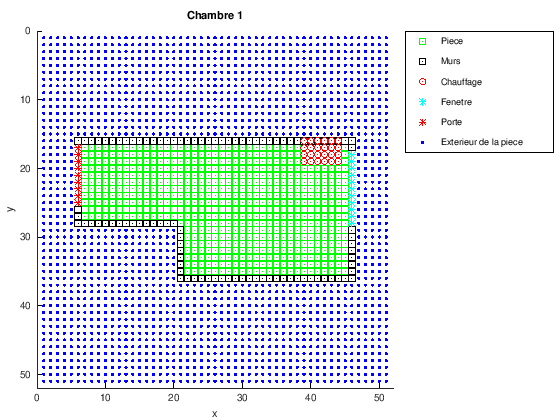

In [7]:
tic
% création du domaine
G1 = rect(-.8, .8, -.4, .4) & !inner_rect(-1, -.2, -1, -.1);
k = find(G1);
N1 = length(k);  % nombre de points dans la chambre 1
G1 = zeros(size(G1));
G1(k) = 1:N1;

% création des différents objets
Heat1 = sparse(G1 & rect(.5, .7, .3, .4));
Door1 = sparse(G1 & rect(-.8, -.8, 0.05, .35));
Wind1 = sparse(G1 & rect(.8, .8, -.1, .3));
[TW1, BW1, LW1, RW1] = walls(G1, Wind1, Door1);
Walls1 = TW1 | BW1 | LW1 | RW1;
"Création chambre 1", toc

% affichage
f = figure();
hold on
spy(G1 & !Heat1 & !Door1 & !Wind1 & !Walls1, "gs")
spy(Walls1, "ks")
spy(Heat1, "ro")
spy(Wind1, "c")
spy(Door1, "r")
spy(!G1, "b.")
legend({"Piece", "Murs", "Chauffage", "Fenetre", "Porte", "Exterieur de la piece"}, "location", "northeastoutside")
title("Chambre 1")
xlabel("x")
ylabel("y")
hold off

if save_img
    file = "geom_chambre1";
    print(f, [pwd folder file ext]);
end

Création de la chambre 2

ans = Création chambre 2
Elapsed time is 0.511577 seconds.


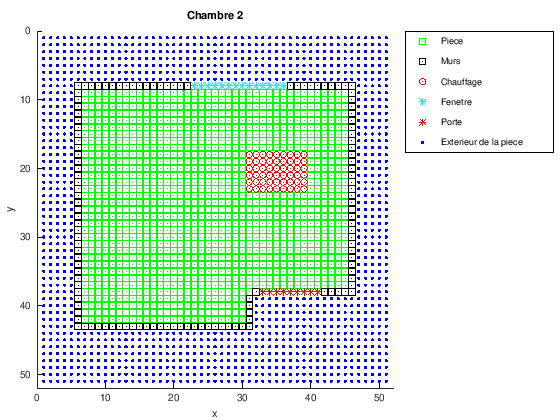

In [8]:
tic
% création du domaine
G2 = rect(-.8, .8, -.7, .7) & !inner_rect(.2, 1, -1, -.5);
k = find(G2);
N2 = length(k);  % nombre de points dans la chambre 1
G2 = zeros(size(G2));
G2(k) = 1:N2;

% création des différents objets
Heat2 = sparse(G2 & rect(.2, .5, .1, .3));
Door2 = sparse(G2 & rect(.3, .6, -.5, -.5));
Wind2 = sparse(G2 & rect(-.1, .4, .7, .7));
[TW2, BW2, LW2, RW2] = walls(G2, Wind2, Door2);
Walls2 = TW2 | BW2 | LW2 | RW2;
"Création chambre 2", toc


% affichage
f = figure();
hold on
spy(G2 & !Heat2 & !Door2 & !Wind2 & !Walls2, "gs")
spy(Walls2, "ks")
spy(Heat2, "ro")
spy(Wind2, "c")
spy(Door2, "r")
spy(!G2, "b.")
legend({"Piece", "Murs", "Chauffage", "Fenetre", "Porte", "Exterieur de la piece"}, "location", "northeastoutside")
title("Chambre 2")
xlabel("x")
ylabel("y")
hold off

if save_img
    file = "geom_chambre2";
    print(f, [pwd folder file ext]);
end

### Écriture matricielle du problème discret

- `A` : matrice de discrétisation du Laplacien divisée par $h^2$ et adaptée aux conditions de Von Neumann
- `f` : vecteur du terme constant (chauffage)
- `b` : vecteurs conditions de Dirichlet et de Von Neumann (contribution nulle car isolation parfaite)

Pour une matrice de $N$ lignes, $k(i,j) = i + N(j-1)$, donc $k(i,i) = i + N(i-1) = (N+1)i - N$.

In [9]:
function [A, b] = forme_matricielle(G, N, Heat, Door, Wind, TW, BW, LW, RW)
    global heatPower, global doorTemp, global windTemp, global h;
    A = delsq(G);
    
    % conditions de Von Neumann dans A
    % approximation d'ordre 2 car isolation parfaite
    % on compte bien les coins deux fois
    A((N+1) * G(TW) - N) -= 1;
    A((N+1) * G(BW) - N) -= 1;
    A((N+1) * G(LW) - N) -= 1;
    A((N+1) * G(RW) - N) -= 1;
    A = -A / h^2;
    
    b = zeros(N, 1);
    b(G(Heat)) += -heatPower;     % Terme constant - chauffage
    b(G(Door)) += -doorTemp/h^2;  % Condition de Dirichlet - porte
    b(G(Wind)) += -windTemp/h^2;  % Condition de Dirichlet - fenêtre
endfunction

tic
[A1, b1] = forme_matricielle(G1, N1, Heat1, Door1, Wind1, TW1, BW1, LW1, RW1);
"Mise sous forme matricielle chambre 1", toc
tic
[A2, b2] = forme_matricielle(G2, N2, Heat2, Door2, Wind2, TW2, BW2, LW2, RW2);
"Mise sous forme matricielle chambre 2", toc

ans = Mise sous forme matricielle chambre 1
Elapsed time is 0.0623779 seconds.
ans = Mise sous forme matricielle chambre 2
Elapsed time is 0.0608749 seconds.


# Partie 1 : calcul de la solution de l'équation de Poisson
Résolution de $Au = b$

In [10]:
function U = Poisson(G, A, b)
    u = A \ b;
    U = G;
    U(G>0) = full(u(G(G>0)));
endfunction

In [11]:
tic
U1 = Poisson(G1, A1, b1);
"Poisson chambre 1", toc
tic
U2 = Poisson(G2, A2, b2);
"Poisson chambre 2", toc

ans = Poisson chambre 1
Elapsed time is 0.0655942 seconds.
ans = Poisson chambre 2
Elapsed time is 0.075408 seconds.


### Affichage de la solution

Chambre 1

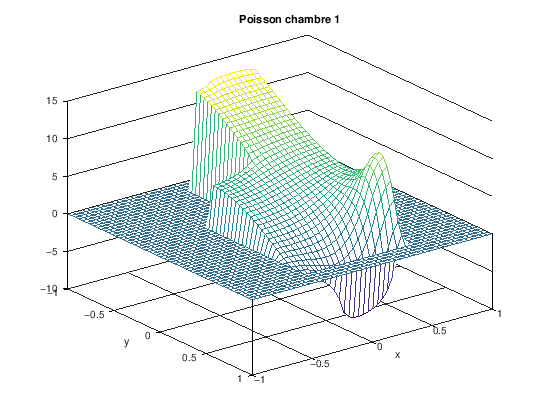

In [12]:
f = figure();
mesh(Y, X, U1);
title("Poisson chambre 1")
xlabel("x")
ylabel("y")
axis('ij');

if save_img
    file = "Poisson_chambre1";
    print(f, [pwd folder file ext]);
end

Chambre 2

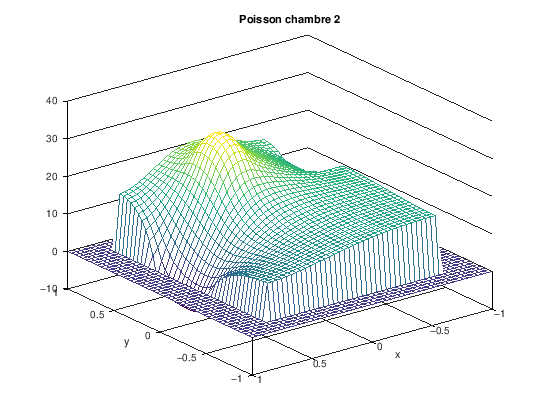

In [13]:
f = figure();
mesh(Y, X, U2);
title("Poisson chambre 2")
xlabel("x")
ylabel("y")
view(azimuth2, 30)
axis('ij');

if save_img
    file = "Poisson_chambre2";
    print(f, [pwd folder file ext]);
end

# Partie 2 : calcul de la solution de l'équation de la chaleur

### 2.1 Compléments de la définition du problème

- `condinit` : fonction qui prend en argument le domaine `G` et donne les conditions initiales en °C
- `Ntemps` : nombre de pas de temps (pour avoir un temps d'exécution indépendant du cfl).
- `nu` : diffusivité en m² / s
- `cfl` : nombre de Courant–Friedrichs–Lewy

Si on préfère fixer un temps final (au risque d'avoir une très longue exécution), on peut trouver `Ntemps` avec : $N_{temps} = \frac{T_{final}}{\Delta{t}}$. Il faut pour cela afficher `deltat` pour connaitre sa valeur en fonction du cfl souhaité.

In [14]:
condinit = @(G) 0 * (G != 0);
Ntemps = 1000;
nu = 1;
cfl = .5;

In [15]:
deltat = cfl*h^2/(2*nu);   % pas de temps respectant la condition nu*deltat/h^2 = nombre de CFL

In [16]:
% nb_etapes : le nombre d'images intermédiaires que l'on veut lors de la visualisation
nb_etapes = 3;  % affiche nb_etapes images
disp_iter = idivide(Ntemps, nb_etapes);
%disp_iter = -1;  % disp_iter = -1 pour ne rien afficher

### 2.2 Euler explicite et implicite

Explicite : $u^{n+1} = (I + \nu \, \Delta{t} \, A) u^n + \Delta{t} \, b$

Implicite : $(I - \nu \, \Delta{t} \, A) u^{n+1} = u^n - \Delta{t} \, b$

Avec décomposition LU : $L \, U \, u^{n+1} = P \, (u^n - \Delta{t} \, b)$


In [17]:
function [U] = Euler(G, A, b, condinit, Ntemps, deltat, nu, methode, disp_iter, num_chambre)
    % méthode : "explicite", "implicite" ou "implicite LU"
    % disp_iter : affiche l'étape i lorsque mod(i, disp_iter) = 1
    %             valeur négative pour ne rien afficher (test des temps d'exécution)
    % nom_chambre : le numéro de la chambre à mettre sur le graphique et dans le nom de fichier
    global X, global Y;
    global azimuth2, global save_img, global folder, global ext;
    expl = "explicite"; impl = "implicite"; impl_lu = "implicite LU";
    U0 = condinit(G);
    u = U0(logical(G));

    if strcmp(methode, expl)
        mat_explicite = eye(size(A)) + nu*deltat*A;
    elseif strcmp(methode, impl)
        mat_implicite = eye(size(A)) - nu*deltat*A;
    elseif strcmp(methode, impl_lu)
        [L, U_, P] = lu(eye(size(A)) - nu*deltat*A);
    else
        "methode non définie"
        U = -1
        return
    end
    
    if disp_iter > 0
        f = figure();
    end
    
    found_first_iter = true;  % à mettre à false pour trouver la première itération telle que...
    for t = 1:Ntemps+1
        if strcmp(methode, expl)
            u = mat_explicite * u - deltat*b;
        elseif strcmp(methode, impl)
            u = mat_implicite \ (u - deltat*b);
        elseif strcmp(methode, impl_lu)
            u = U_\(L\(P*(u - deltat*b)));
        end
        
        % pour trouver la première itération telle que...
        % if !found_first_iter && max(u) > 20
        if !found_first_iter && min(u) < 25
            t
            t*deltat
            found_first_iter = true;
        end
        
        % affichage
        if mod(t, disp_iter) == 1
            U = G;
            U(G>0) = full(u(G(G>0)));
            mesh(Y, X, U);
            figname = ["Euler " methode " chambre " num2str(num_chambre) ", Iteration " num2str(t) "/" num2str(Ntemps+1)];
            title(figname);
            if num_chambre == 2
                view(azimuth2, 30)
            end
            xlabel("y");
            ylabel("x");
            axis('ij');
            if save_img
                subfolder = fullfile(folder, ["Euler_" methode "_chambre_" num2str(num_chambre)]);
                mkdir(fullfile(pwd,subfolder));
                file = [num2str(idivide(t, disp_iter) + 1) "-" num2str(idivide(Ntemps, disp_iter) + 1)];
                print(f, [pwd subfolder "\\" file ext]);
            end
            pause(0.1);
        end
    end
    U = G;
    U(G>0) = full(u(G(G>0)));
endfunction

Explicite

ans = Euler explicite chambre 2
Elapsed time is 1.253 seconds.


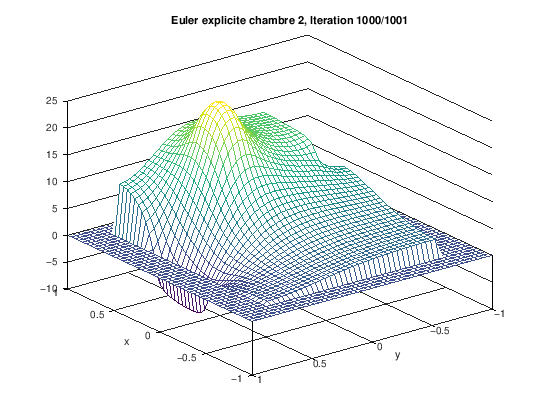

In [18]:
%tic
%U1_E = Euler(G1, A1, b1, condinit, Ntemps, deltat, nu, "explicite", disp_iter, 1);
%"Euler explicite chambre 1", toc
tic
U2_E = Euler(G2, A2, b2, condinit, Ntemps, deltat, nu, "explicite", disp_iter, 2);
"Euler explicite chambre 2", toc

Implicite avec décomposition LU

    Euler at line 17 column 20
ans = Euler implicite LU chambre 2
Elapsed time is 1.32122 seconds.


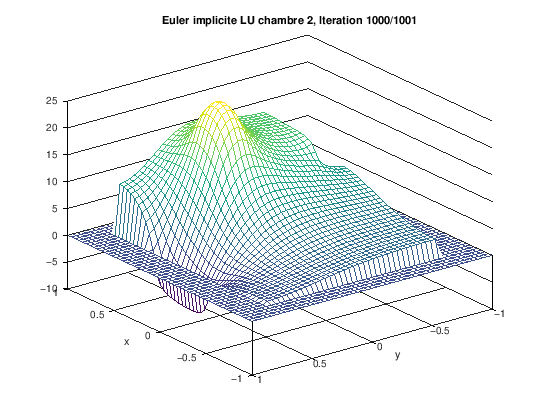

In [19]:
%tic
%U1_I_LU = Euler(G1, A1, b1, condinit, Ntemps, deltat, nu, "implicite LU", disp_iter, 1);
%"Euler implicite LU chambre 1", toc
tic
U2_I_LU = Euler(G2, A2, b2, condinit, Ntemps, deltat, nu, "implicite LU", disp_iter, 2);
"Euler implicite LU chambre 2", toc

Implicite

ans = Euler implicite chambre 2
Elapsed time is 2.54735 seconds.


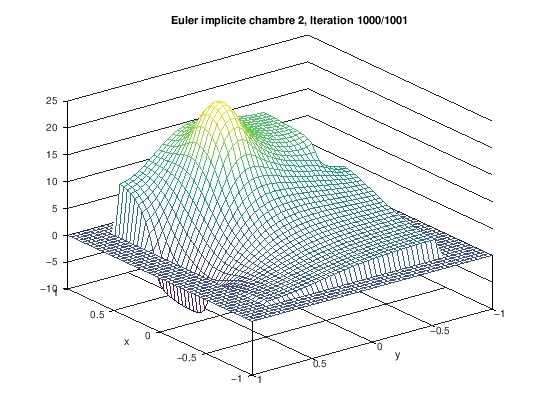

In [20]:
%tic
%U1_I = Euler(G1, A1, b1, condinit, Ntemps, deltat, nu, "implicite", disp_iter, 1);
%"Euler implicite chambre 1", toc
tic
U2_I = Euler(G2, A2, b2, condinit, Ntemps, deltat, nu, "implicite", disp_iter, 2);
"Euler implicite chambre 2", toc